In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt
%matplotlib inline
import os
import sys 
from tqdm import tqdm
sys.path.append('/home/drdarby/Desktop/cape_mend_SM_LCS/datatools')
import datatools as tools
import cmocean as cm
from scipy.interpolate import griddata
import xgcm
print(xgcm.__path__)


['/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/xgcm']


In [105]:
path = '/media/drdarby/Elements/data/N_Greenland/solution_output/heat_budget/'
snapshot_files, snapshot_filepath = tools.get_data_paths_from_binary(path,'heat_budget/snapshots',file_end='nc')
data_files, data_filepath = tools.get_data_paths_from_binary(path,'heat_budget/',file_end='nc')
grid_filepath = '/media/drdarby/Elements/data/L1_llc1080/L1_N_Greenland_grid.nc'
grid = xr.open_dataset(grid_filepath)
data = xr.open_mfdataset(data_filepath)
theta_eta_snap = xr.open_mfdataset(snapshot_filepath)

In [106]:
#make vertical component and lat/lon agree between data and grid:
grid = grid.rename({'Z':'depths'})
grid.coords['depths'] = np.array(data.depths)
grid = grid.set_coords(['XC','YC']).rename({'XC':'longitude','YC':'latitude'})

### Heat budget equation
The heat budget for the MITgcm is based on this equation:

$\frac{\partial \theta}{\partial t}$ $=$ $-$ $\nabla$ $\cdot$ $(\theta$ $\mathbf{u})$ $-$ $\nabla$ $\cdot$ $F_{\textrm{diff}}^{\theta}$ $+$ ${F}_\textrm{forc}^{\theta}$

where, $\frac{\partial \theta}{\partial t}$ is the change in potential temperature over time. The equation above describes this change as a function of the convergence (the $-\nabla \cdot$ operator) of heat advection and diffusion with the addition of any forcing terms.

In order to simulate this equation and be used for MITgcm, a two steps are needed. 1) A coordinate change to best represent the free surface with fixed depth bins $z^* = \frac{z - \eta}{H + \eta}H $, where $\eta$ and $H$ are the displacement of the ocean surface and the ocean depth respectively, and 2) the residual mean velocities,

$v_{res}$ = $(u_{res},v_{res},w_{res})$ $=$ $(u,v,w)$ $+$ $(u_b,v_b,w_b)$, 

that parameterizes unresolved eddies. From step 1, our coordinate change introduces a scaling factor $s^* = 1+ \frac{\eta}{H}$ as well as a change to our horizontal and vertical divergences, $ ( \nabla_z^* $ and $\frac{\partial}{\partial z^{*}} )$, which are seperated, leading to our final equation:

$\frac{\partial(s^*\theta)}{\partial t}$ $=$ $-\nabla_{z^{*}}$ $\cdot(s^*\theta\,\mathbf{v}_{res})$ $-\frac{\partial(\theta\,w_{res})}{\partial z^{*}}$ $-$ $s^*$ $(\nabla\cdot\mathbf{F}_\textrm{diff}^{\theta})$$+$$s^*$ ${F}_\textrm{forc}^{\theta}$

In order to make the calculation a bit easier on the eyes the different budget terms will be seperated into: 

$\underbrace{\frac{\partial(s^*\theta)}{\partial t}}_{G^{\theta}_\textrm{total}} = \underbrace{-\nabla_{z^{*}} \cdot(s^*\theta\,\mathbf{v}_{res}) - \frac{\partial(\theta\,w_{res})}{\partial z^{*}}}_{G^{\theta}_\textrm{advection}}\underbrace{- s^* ({\nabla\cdot\mathbf{F}_\textrm{diff}^{\theta}})}_{G^{\theta}_\textrm{diffusion}} + \underbrace{s^* {F}_\textrm{forc}^{\theta}}_{G^{\theta}_\textrm{forcing}}$

Making our budget equation: $G^{\theta}_\textrm{total} = G^{\theta}_\textrm{advection} + G^{\theta}_\textrm{diffusion} + G^{\theta}_\textrm{forcing}$

### Converting to MITgcm output

#### Calculating $G^{\theta}_\textrm{total}$
In order to calculate the $G^{\theta}_\textrm{total}$ snapshots of our model feild are needed for $\eta$ and $\theta$. This is because averaging these fields would smooth out variability and we would lose information.

$G^{\theta}_\textrm{total} = \frac{\partial(s^*\theta)}{\partial t} = \frac{\partial(1+ \frac{\eta}{H}) \theta}{\partial t}$
in terms of our variables our $G^{\theta}_\textrm{total}$ would be:
$=$ 
```sTHETA.diff(dim = 'time') = THETA_snapshot*(1+ETAN_snapshot/grid.Depth).diff(dim = 'time')```

where ```.diff(dim= 'time')``` is the numpy difference function with respect to the time column, and grid.Depth is the Depth vaiable from out MITgcm grid.




In [1]:
#convert data to usable time
sec_itr_1080 = 300
def date_to_iter_number(date,seconds_per_iter = 60):

    total_seconds = (date-datetime(1992,1,1)).total_seconds()
    iter_number = total_seconds/seconds_per_iter
    # print(iter_number)
    return(iter_number)

def iter_number_to_date(iter_number,seconds_per_iter=60):

    total_seconds = iter_number*seconds_per_iter
    date = datetime(1992,1,1) + timedelta(seconds=total_seconds)
    # print(date)
    return(date)
time_snap = []
for i in range(0,12):
    t_date = iter_number_to_date(np.array(theta_eta_snap.iterations)[i],seconds_per_iter=sec_itr_1080)
    time_snap.append(t_date)

theta_eta_snap.coords['iterations'] = np.array(time_snap) #make our iteration values time values
theta_eta_snap = theta_eta_snap.rename({'iterations':'time'}) #rename iteration to time
time_data = []
for i in range(0,12): #translate iteration number to time
    t_date = iter_number_to_date(np.array(data.iterations)[i],seconds_per_iter=sec_itr_1080)
    time_data.append(t_date)
data.coords['iterations'] = np.array(time_data)#make our iteration values time values
data = data.rename({'iterations':'time'})#rename iteration to time
theta_eta_snap = theta_eta_snap.rename({'rows':'Y','cols':'X'}) #rename rows and cols to Y and X vars
data = data.rename({'rows':'Y','cols':'X'})
#data = data.isel(time=slice(1,12)) #make data length time ~ time of snapshots after diff.

NameError: name 'np' is not defined

In [ ]:
data = data.isel(time=slice(0,11)) 

In [5]:
#compute our d s*Theta term
sTHETA = theta_eta_snap['Theta']*(1+theta_eta_snap['ETAN']/grid.Depth.where(grid.Depth!=0))
d_sTHETA = sTHETA.diff(dim='time')
d_sTHETA.coords['time'] = np.array(data.time)

In [6]:
delta_t = sTHETA['time'].diff(dim='time',label='lower')/np.timedelta64(1,'s')
delta_t.coords['time'] = np.array(data.time)
sTHETA.close()


In [7]:
d_sTHETA_dt = d_sTHETA/delta_t
d_sTHETA.close()

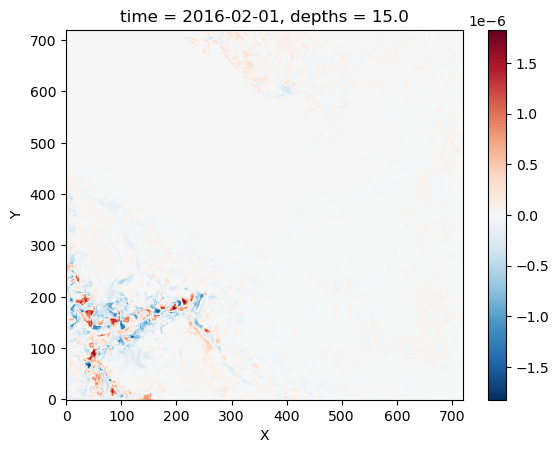

In [31]:
d_sTHETA_dt.isel(depths=1,time=0).plot()

### Calculating $G^{\theta}_\textrm{advection}$

At first glance, in order to calculate our $G^{\theta}_\textrm{horizontal advection} = -\nabla_{z^{*}} \cdot(s^*\theta\,\mathbf{v}_{res})$  equation, some tough coding are needed. Fortunately, there exists output of the $\theta$ advection terms in the x and y.

Making our equation $G^{\theta}_\textrm{horizontal advection}$:
$=$
```-1*(ADVx_TH.diff(dim='X') + ADVy_TH.diff(dim='Y'))```


next we calculate our vertical advection term $G^{\theta}_\textrm{vertical advection} = - \frac{\partial(\theta\,w_{res})}{\partial z^{*}}$

$=$
```ADVr_TH.diff(dim='Z')```

putting it all together we have,

$G^{\theta}_\textrm{advection}$ = ```(-1*(ADVx_TH.diff(dim='X') + ADVy_TH.diff(dim='Y')) + ADVr_TH.diff(dim='Z'))/volume```

where,
```volume = (grid.rA*grid.drF*grid.hFacC)```

In [19]:
CellVol = grid['rA'] * grid['drF'] * grid['HFacC']
#grid['CellVol'] = CellVol

In [20]:
depths = data.depths
#horizontal and vertical advection
adv_hz_x = data['ADVx_TH'].where(grid.HFacC.values > 0,0).diff(dim='X',label='lower') #selecting non-land points, ''
adv_hz_y = data['ADVy_TH'].where(grid.HFacC.values > 0,0).diff(dim='Y',label='lower')
adv_vt = data['ADVr_TH'].where(grid.HFacC.values > 0,0).diff(dim='depths',label='lower')

G_adv = (-1*(adv_hz_x[:,:-1,:-1,:] + adv_hz_y[:,:-1,:,:-1]) + adv_vt[:,:,:-1,:-1])/CellVol[:-1,:-1,:-1].where(CellVol[:-1,:-1,:-1]!=0)

<xarray.DataArray (time: 11, depths: 49, Y: 719, X: 719)>
dask.array<truediv, shape=(11, 49, 719, 719), dtype=float32, chunksize=(11, 49, 719, 719), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2016-02-01 2016-03-01 ... 2016-12-01
  * depths     (depths) float32 5.0 15.0 25.0 ... 4.64e+03 5.039e+03 5.461e+03
    longitude  (Y, X) float32 25.49 25.52 25.54 25.57 ... -101.2 -101.3 -101.4
    latitude   (Y, X) float32 71.38 71.41 71.44 71.47 ... 71.43 71.42 71.41
Dimensions without coordinates: Y, X

#### Calculating $G^{\theta}_\textrm{diffusion}$


The form of our diffusion term is almost identical to our advection term except for the variables used. Our horizontal and vertical components are:

$G^{\theta}_\textrm{horizontal diffusion}$
$=$ ```-1*(DFxE.diff(dim='X') + DFyE.diff(dim='Y')))```

and, 
$G^{\theta}_\textrm{vertical diffusion}$ $=$ ```DFrE_TH.diff(dim='Z') + DFrI_TH.diff(dim='Z')```


In [22]:
DFxE_TH = data['DFxE_TH'].where(grid.HFacC.values > 0,0)
DFyE_TH = data['DFyE_TH'].where(grid.HFacC.values > 0,0)
DFrE_TH = data['DFrE_TH'].where(grid.HFacC.values > 0,0)
DFrI_TH = data['DFrI_TH'].where(grid.HFacC.values > 0,0)

Making our final $G^{\theta}_\textrm{diffusion}$ term:

$G^{\theta}_\textrm{diffusion} = $ ``` (-1*(DFxE.diff(dim='X') + DFyE.diff(dim='Y')) + DFrE_TH.diff(dim='Z') + DFrI_TH.diff(dim='Z'))/volume```

If you are using the KPP parameter, the KPP term has to be added to the $G^{\theta}_\textrm{diffusion}$.

$G^{\theta}_\textrm{diffusion with kpp} = $ ``` (-1*(DFxE.diff(dim='X') + DFyE.diff(dim='Y')) + DFrE_TH.diff(dim='Z') + DFrI_TH.diff(dim='Z')+KPPg_TH.diff(dim='Z'))/volume```

In [23]:
dif_hConvH = -1*(DFxE_TH.diff('X',label='lower')[:,:-1,:-1] + DFyE_TH.diff('Y',label='lower')[:,:-1,:,:-1])
dif_vConvH = DFrE_TH.diff('depths',label='lower')+DFrI_TH.diff('depths',label='lower')
Kpp_tend = data['KPPg_TH'].diff('depths',label='lower')
G_diff = (dif_hConvH + dif_vConvH[:,:,:-1,:-1]+Kpp_tend[:,:,:-1,:-1])/CellVol[:-1,:-1,:-1].where(CellVol[:-1,:-1,:-1]!=0)

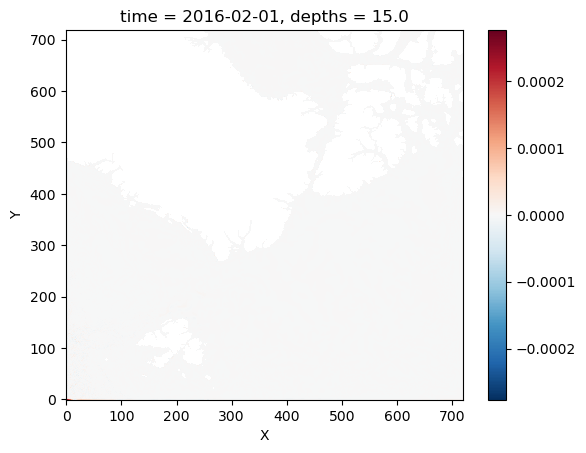

In [86]:
G_diff.isel(time=0,depths=1).plot()


#### Calculating $G^{\theta}_\textrm{forcing}$

To complete our heat budget we must finally calculate our forcing term. This term consists of surface and subsurface forcing, including shortwave radiation and temperature flux. These are ultimatly subtracted from one another, however, the shortwave radiation is scaled by its penetration depth into the water column eventually zeroing out.

#### constants:

In [71]:
# Seawater density (kg/m^3)
rhoConst = 1027.5
## needed to convert surface mass fluxes to volume fluxes
# Heat capacity (J/kg/K)
c_p = 3994
# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

In [73]:
#
q1 = np.array(R*np.exp(1.0/zeta1*-1*depths[:-1]) + (1.0-R)*np.exp(1.0/zeta2*-1*depths[:-1]))
q2 = np.array(R*np.exp(1.0/zeta1*-1*depths[1:]) + (1.0-R)*np.exp(1.0/zeta2*-1*depths[1:]))
q1 = np.append(q1,0)
q2 = np.append(q2,0)
q1 = xr.DataArray(q1,coords=[depths],dims=['depths'])
q2 = xr.DataArray(q2,coords=[depths],dims=['depths'])
q1 = q1.where(depths<200,0) #correction for no heat pen past 200m
q2 = q2.where(depths<200,0)
mskC = grid.HFacC.copy(deep=True).compute()
WM = -1*data['WTHMASS']/(grid['drF']*grid['HFacC'].where(CellVol!=0)) #surface tendancy correction

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(depths=-1)==1))*data['oceQsw']).transpose('time','depths','Y','X').isel(depths=slice(1,50))
# Surface heat flux (W/m^2)
forcH_surf = ((data['TFLUX'] - (1-(q1[0]-q2[0]))*data['oceQsw']+WM.isel(depths=0))\
              *mskC[0]).transpose('time','Y','X').assign_coords(depths=5.0).expand_dims('depths')
# Qsw_tend = oceQsw['oceQsw'] / (rhoConst * c_p) / (grid['DRF']* grid['hFacC']) * (q1 -q2) 
# Tflx_tend = (TFLUX['TFLUX'] - oceQsw) / (rhoConst * c_p * grid['DRF'][0] *grid['hFacC'])
# forcH_surf =(TFLUX['TFLUX'] - (1-(q1[0]-q2[0]))*oceQsw['oceQsw'])
# forcH_subsurf = (q1[1:]-q2[1:]*oceQsw['oceQsw'])

forcH = xr.concat([forcH_surf,forcH_subsurf], dim='depths')
G_forcing = ((forcH)/(rhoConst*c_p))/(grid['HFacC']*grid['drF'].where(CellVol!=0))

In [ ]:
G_forcing

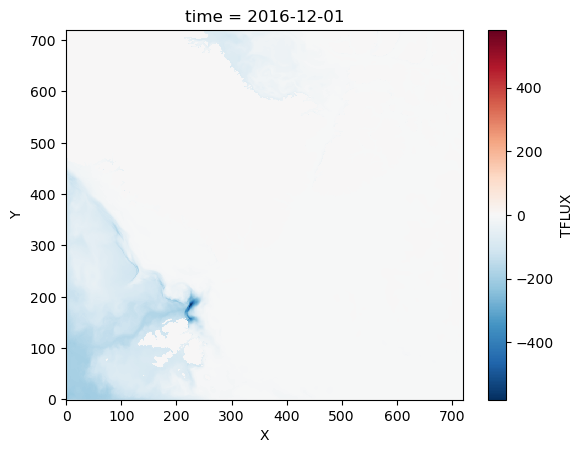

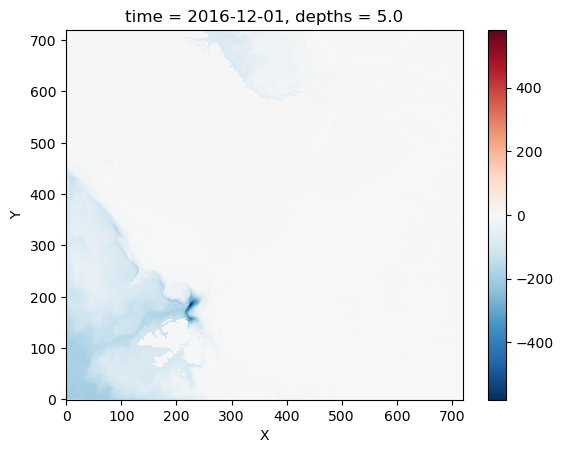

In [42]:
data['TFLUX'].isel(time=10).plot()
plt.show()
forcH_surf.isel(time=10).plot()


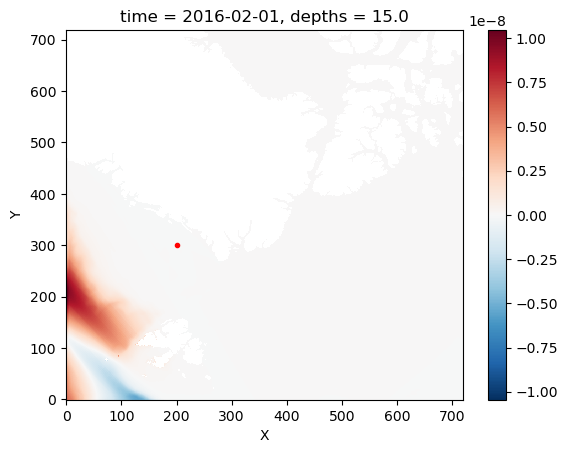

In [31]:
G_forcing[:,:-1,:-1,:-1].isel(depths=1,time=0).plot(label='total')
plt.plot(200,300,'r.')

In [74]:
plt.close()

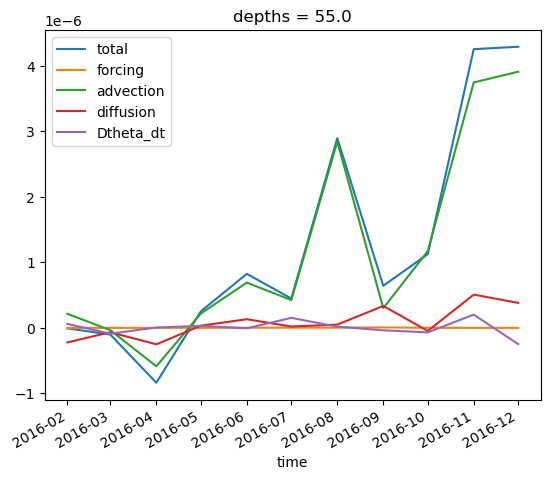

In [75]:
##Checking surface agreement
k=5
(G_forcing[:,:,:-1,:-1].isel(depths=k,Y=200,X=300) + G_adv.isel(depths=k,Y=200,X=300) + G_diff.isel(depths=k,Y=200,X=300)).plot(label='total')
G_forcing[:-1,:].isel(depths=k,Y=200,X=300).plot(label='forcing')
G_adv.isel(depths=k,Y=200,X=300).plot(label='advection')
G_diff.isel(depths=k,Y=200,X=300).plot(label='diffusion')
d_sTHETA_dt.isel(depths=k,Y=200,X=300).plot(label='Dtheta_dt')
#plt.ylim(-1e-6,1e-6)
plt.legend()

In [17]:
plt.close()

In [ ]:
##Checking subsurface agreement
(G_forcing[:,:,:-1,:-1].isel(Y=200,X=300) + G_adv.isel(Y=200,X=300) + G_diff.isel(Y=200,X=300)).mean(dim='depths').plot(label='total')
G_forcing[:-1,:].isel(depths=slice(1,49),Y=200,X=300).mean(dim='depths').plot(label='forcing')
(G_adv.isel(Y=200,X=300).mean(dim='depths')/10).plot(label='advection')
G_diff.isel(Y=200,X=300).mean(dim='depths').plot(label='diffusion')
d_sTHETA_dt.isel(Y=200,X=300).mean(dim='depths').plot(label='Dtheta_dt')
#plt.ylim(-1e-6,1e-6)
plt.legend()

### Volume budget

In [145]:
path_vol = '/media/drdarby/Elements/data/N_Greenland/solution_output/Volume_budget'
d_eta = theta_eta_snap['ETAN'].diff(dim='time')
delta_t = theta_eta_snap['time'].diff(dim='time')/np.timedelta64(1,'s')
d_eta_dt = d_eta/delta_t

In [109]:
d_eta_dt

<xarray.DataArray (time: 11, Y: 720, X: 720)>
dask.array<truediv, shape=(11, 720, 720), dtype=float64, chunksize=(11, 720, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-02-16 2016-03-16 ... 2016-12-16
Dimensions without coordinates: Y, X

In [146]:
oceFWflx_files, oceFWflx_filepaths = tools.get_data_paths_from_binary(path_vol, '', file_end = 'nc' )
#oceFWflx = xr.open_mfdataset(oceFWflx_filepaths).isel(tile=6)
#WVELMASS_files, WVELMASS_filepaths = tools.get_data_paths_from_binary(path_llc270, 'WVELMASS', file_end = 'nc' )
#WVELMASS = xr.open_mfdataset(WVELMASS_filepaths).isel(tile=6)
oceFWflx_filepaths

['/media/drdarby/Elements/data/N_Greenland/solution_output/Volume_budget/UVELMASS_2016.nc',
 '/media/drdarby/Elements/data/N_Greenland/solution_output/Volume_budget/VVELMASS_2016.nc',
 '/media/drdarby/Elements/data/N_Greenland/solution_output/Volume_budget/oceFWflx_2016.nc']

In [177]:
rhoConst = 1029 #1027.5 
rhoConst = 1027.5

In [148]:
oceFWflx = xr.open_mfdataset(oceFWflx_filepaths[-1]).rename({'rows':'Y','cols':'X'})


In [149]:
UVELMASS = xr.open_mfdataset(oceFWflx_filepaths[0]).rename({'rows':'Y','cols':'X'})
VVELMASS = xr.open_mfdataset(oceFWflx_filepaths[1]).rename({'rows':'Y','cols':'X'})

In [178]:
G_surf_flx = oceFWflx['oceFWflx']/rhoConst

In [104]:
G_surf_flx

<xarray.DataArray 'oceFWflx' (iterations: 12, Y: 720, X: 720)>
dask.array<truediv, shape=(12, 720, 720), dtype=float32, chunksize=(12, 720, 720), chunktype=numpy.ndarray>
Coordinates:
  * iterations  (iterations) float32 2.534e+06 2.542e+06 ... 2.621e+06 2.63e+06
Dimensions without coordinates: Y, X

In [15]:
def diff_2d_flux_HH(flux_vector_dict):
    """
    A function (similar to xgcm.Grid.diff_2d_vector) that differences flux variables on the HH Arctic grid.
    """

    u_flux = flux_vector_dict['X']
    v_flux = flux_vector_dict['Y']

    u_flux_padded = u_flux.pad(pad_width={'X':(1,0)},mode='constant',constant_values=np.nan)
    v_flux_padded = v_flux.pad(pad_width={'Y':(1,0)},mode='constant',constant_values=np.nan)

    # take differences
    diff_u_flux = u_flux_padded.diff('X')
    diff_v_flux = v_flux_padded.diff('Y')

    # include coordinates of input DataArrays and correct dimension/coordinate names
    diff_u_flux = diff_u_flux.assign_coords(u_flux.coords)#.rename({'i_g':'i'})
    diff_v_flux = diff_v_flux.assign_coords(v_flux.coords)#.rename({'j_g':'j'})

    diff_flux_vector_dict = {'X':diff_u_flux,'Y':diff_v_flux}

    return diff_flux_vector_dict

In [22]:
grid.

<xarray.Dataset>
Dimensions:    (Y: 720, X: 720, Xp1: 721, Yp1: 721, depths: 50)
Coordinates:
    longitude  (Y, X) float32 ...
    latitude   (Y, X) float32 ...
  * depths     (depths) float32 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
Dimensions without coordinates: Y, X, Xp1, Yp1
Data variables: (12/14)
    XG         (Y, X) float32 ...
    YG         (Y, X) float32 ...
    AngleCS    (Y, X) float32 ...
    AngleSN    (Y, X) float32 ...
    dxC        (Y, Xp1) float32 ...
    dyC        (Yp1, X) float32 ...
    ...         ...
    HFacC      (depths, Y, X) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    HFacW      (depths, Y, Xp1) float32 ...
    HFacS      (depths, Yp1, X) float32 ...
    drF        (depths) float32 ...
    Depth      (Y, X) float32 ...
    rA         (Y, X) float32 ...

In [179]:

vol_transport_x = UVELMASS['UVELMASS'] * grid.dyG[:,:-1].rename({'Xp1':'X'}) * grid.drF
vol_transport_y = VVELMASS['VVELMASS'] * grid.dxG[:-1,:].rename({'Yp1':'Y'}) * grid.drF
vol_transport_x = vol_transport_x.where(grid.HFacC.values > 0,0)
vol_transport_y = vol_transport_y.where(grid.HFacC.values > 0,0)


# Difference of horizontal transports in x and y directions
#vol_flux_diff = diff_2d_flux_HH({'X': vol_transport_x, \
#                                 'Y': vol_transport_y})

#vol_horiz_divergence = (vol_flux_diff['X'] + vol_flux_diff['Y'])


vol_horiz_divergence = vol_transport_x.diff(dim='X',label='lower')[:,:,:-1,:] + vol_transport_y.diff(dim='Y',label='lower')[:,:,:,:-1]
G_vol_horiz_divergence = -vol_horiz_divergence/grid.rA[:-1,:-1]
G_vol_horiz_divergence_integrated = G_vol_horiz_divergence.sum('depths',skipna=True)

In [176]:
G_vol_horiz_divergence_integrated

<xarray.DataArray (time: 12, Y: 719, X: 719)>
dask.array<sum-aggregate, shape=(12, 719, 719), dtype=float32, chunksize=(12, 719, 719), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2016-02-01 2016-03-01 ... 2017-01-01
    longitude  (Y, X) float32 ...
    latitude   (Y, X) float32 ...
Dimensions without coordinates: Y, X

In [34]:
data.time

<xarray.DataArray 'time' (time: 11)>
array(['2016-02-01T00:00:00.000000000', '2016-03-01T00:00:00.000000000',
       '2016-04-01T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '2016-06-01T00:00:00.000000000', '2016-07-01T00:00:00.000000000',
       '2016-08-01T00:00:00.000000000', '2016-09-01T00:00:00.000000000',
       '2016-10-01T00:00:00.000000000', '2016-11-01T00:00:00.000000000',
       '2016-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-02-01 2016-03-01 ... 2016-12-01

In [180]:
G_surf_flx = G_surf_flx.rename({'iterations':'time'}).isel(time=slice(0,12))
G_vol_horiz_divergence_integrated = G_vol_horiz_divergence_integrated.rename({'iterations':'time'}).isel(time=slice(0,12))
G_surf_flx.coords['time'] = data.time
G_vol_horiz_divergence_integrated.coords['time'] = data.time

<xarray.DataArray (time: 0, Y: 720, X: 720)>
dask.array<truediv, shape=(0, 720, 720), dtype=float64, chunksize=(0, 720, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 
Dimensions without coordinates: Y, X

In [118]:
data.time

<xarray.DataArray 'time' (time: 12)>
array(['2016-02-01T00:00:00.000000000', '2016-03-01T00:00:00.000000000',
       '2016-04-01T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '2016-06-01T00:00:00.000000000', '2016-07-01T00:00:00.000000000',
       '2016-08-01T00:00:00.000000000', '2016-09-01T00:00:00.000000000',
       '2016-10-01T00:00:00.000000000', '2016-11-01T00:00:00.000000000',
       '2016-12-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-02-01 2016-03-01 ... 2017-01-01

In [181]:
d_eta_dt.coords['time'] = data.isel(time=slice(1,12)).time

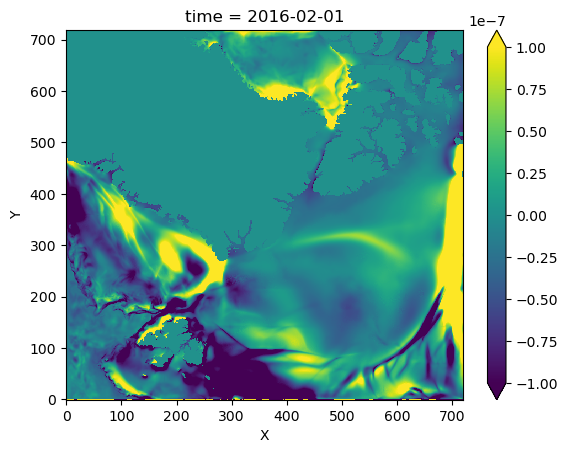

In [42]:
G_vol_horiz_divergence_integrated.isel(X=200,Y=400).plot(vmin=-1e-7,vmax=1e-7)
#G_surf_flx.isel(time=0).plot(vmin=-1e-7,vmax=1e-7)


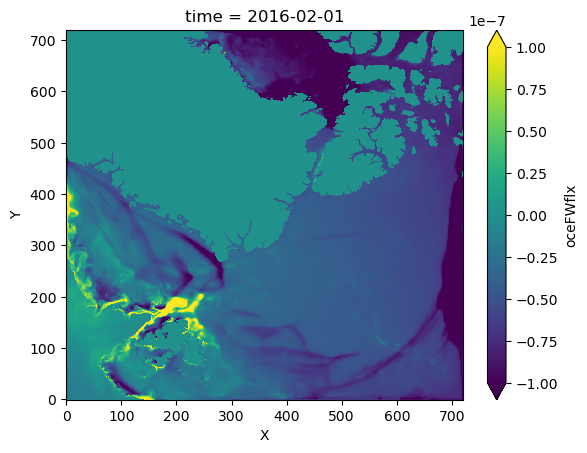

In [43]:
G_surf_flx.isel(time=0).plot(vmin=-1e-7,vmax=1e-7)


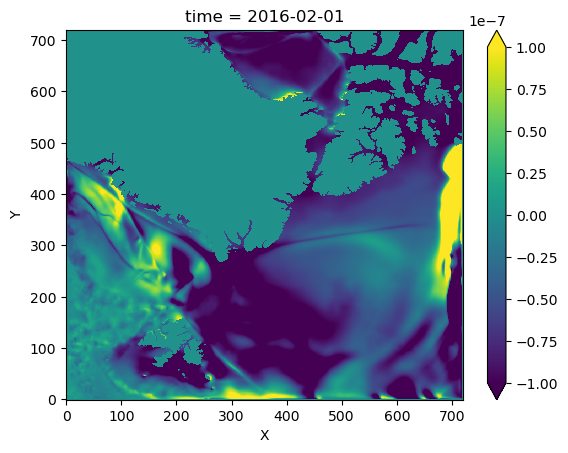

In [54]:
d_eta_dt.isel(time=0).plot(vmin=-1e-7,vmax=1e-7)

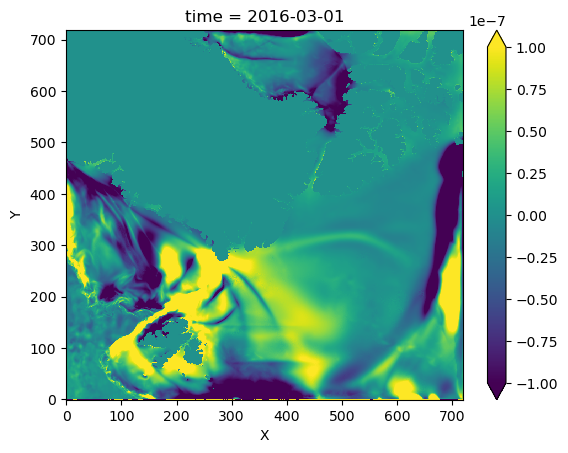

In [141]:
(d_eta_dt.isel(time=0)-G_vol_horiz_divergence_integrated.isel(time=slice(1,12)).isel(time=0) - G_surf_flx.isel(time=slice(1,12)).isel(time=0)[-1,-1]).plot(vmin=-1e-7,vmax=1e-7)


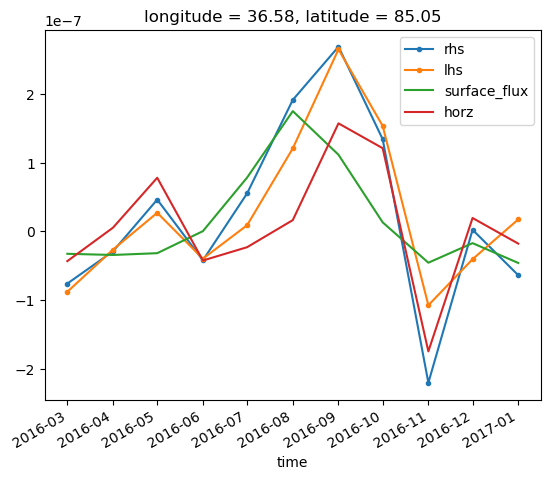

In [182]:
d_eta_dt.isel(time=1)[-1,-1] 
(G_vol_horiz_divergence_integrated.isel(time=slice(1,12)).sel(X=400,Y=100)+ G_surf_flx.sel(X=400,Y=100).isel(time=slice(1,12))).plot(label = 'rhs',marker='.')
d_eta_dt.sel(X=400,Y=100).plot(label='lhs',marker='.')
G_surf_flx.sel(X=400,Y=100).isel(time=slice(1,12)).plot(label='surface_flux')
G_vol_horiz_divergence_integrated.isel(time=slice(1,12)).sel(X=400,Y=100).plot(label='horz')
plt.legend()
#plt.ylim([-1.e-7,1.e-7])

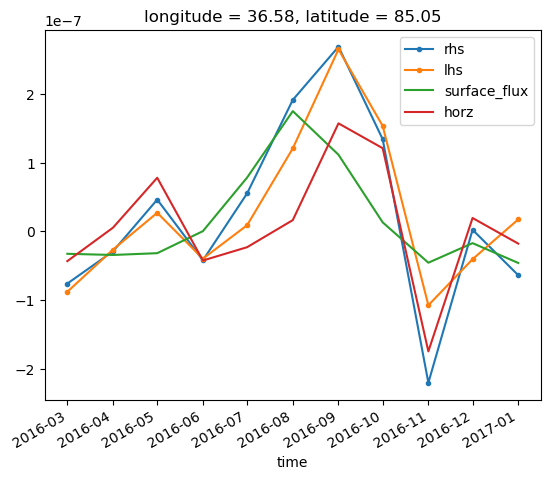

In [161]:
(G_vol_horiz_divergence_integrated.isel(time=slice(1,12)).sel(X=400,Y=100)+ G_surf_flx.sel(X=400,Y=100).isel(time=slice(1,12))).plot(label = 'rhs',marker='.')
d_eta_dt.sel(X=400,Y=100).plot(label='lhs',marker='.')
G_surf_flx.sel(X=400,Y=100).isel(time=slice(1,12)).plot(label='surface_flux')
G_vol_horiz_divergence_integrated.isel(time=slice(1,12)).sel(X=400,Y=100).plot(label='horz')
plt.legend()

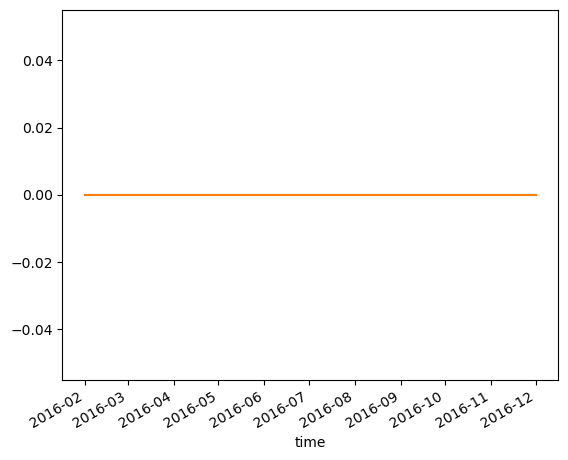

In [51]:
G_surf_flx.isel(X=200,Y=400).plot()
d_eta_dt.isel(X=200,Y=400).plot()


In [47]:
#risidual looks like sea ice, maybe subtracting the ice volume will close it?

In [ ]:
#cont rho may be different.

#WVEL is wrong and weird.